# Election results with barycenter labeling
This notebook creates vote share boxplots by labeled district using and ensemble and its barycenter. 
Inputs required: 
- a shapefile or graph
- an ensemble saved as a list of assignment dictionaries
- barycenter and indexings for this ensemble

Example inputs for Iowa are included in this repo.

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from gerrychain import Graph, Partition, updaters, Election
import pickle
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment as LSA
import littlehelpers
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
from collections import defaultdict
from higher_bary import find_barycenter, planar_discrete_barycenter, planar_discrete_distance, k_means, match_to_mean

In [2]:
def plot_discrete_distribution(mu, ax=None, **kwargs):
    if ax==None:
        ax=plt.gca()
    ax.scatter(
        [x[0] for x in mu],
        [x[1] for x in mu],
        **kwargs
    )
def plot_distribution_family(mus, cmap=None, ax=None, **kwargs):
    '''
    mus is a list of discrete distribution
    '''
    if cmap is None:
        my_cmap = plt.get_cmap('tab20')
    else:
        my_cmap = cmap
    for i, mu in enumerate(mus):
        plot_discrete_distribution(mu, c=np.array([my_cmap(i)]), ax=ax, **kwargs)

## Inputs

In [3]:
#graph = Graph.from_json('') 
graph = Graph.from_file('IA_counties/IA_counties.shp') #replace this with the line above if you have a .json already
gdf = gpd.read_file('IA_counties/IA_counties.shp')
gdf = gdf.to_crs('epsg:2794') #projection which should match the projection used during sampling

/opt/miniconda3/envs/work38/lib/python3.8/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [4]:
plans = pickle.load(open('IA_results/parts_k4.p', 'rb')) #pre-saved plans
B = np.load("IA_results/barycenters_k4_M40_n1000.npy")[0][0] #barycenter
I = np.load("IA_results/indexings_k4_M40_n1000.npy")[0] #indexings
election_name = 'PRES16' #choose whatever name you like here
election_columns = ['PRES16D', 'PRES16R'] #dem and rep vote columns on gdf

## Make the box plots

In [5]:
elections = [
    Election(
        election_name,
        {"Democratic": election_columns[0], "Republican": election_columns[1]},
    )
]
myupdaters = {election.name: election for election in elections}
k = max(plans[0].values())+1

In [6]:
canonical_orders = {}
vote_shares = {}

#reindex plans to the barycenter
reindexed_plans = []
for p, indexing in zip(plans, I):
    plan_to_mean = {x:i for i, x in enumerate(indexing)}
    reindexed_plan = {x:plan_to_mean[y] for x,y in p.items()}
    reindexed_plans.append(Partition(graph, reindexed_plan, myupdaters))

#pick a canonical ordering based on the mean vote shares of the neutral ensemble
ps = [plan for j, plan in enumerate(reindexed_plans)]
mean_vote_shares = {i:[] for i in range(k)}
for p in ps:
    for i, x in zip(p.parts, p[election_name].percents('Democratic')):
        mean_vote_shares[i].append(x)
mean_vote_shares = {
    i: np.mean(x) for i, x in mean_vote_shares.items()
}
canonical_order = sorted(range(k), key = lambda x: mean_vote_shares[x])

#get D vote shares
vote_shares = []
for p in [plan for j, plan in enumerate(reindexed_plans)]:
    vote_shares_by_district = {
        i: x for i, x in zip(p.parts, p[election_name].percents('Democratic'))
    }
    vote_shares.append(
        [vote_shares_by_district[j] for j in canonical_order]
    )

#reindex again
mean_to_canonical_mean = {x:i for i,x in enumerate(canonical_order)}
reindexed_plans = []
for p, indexing in zip(plans, I):
    plan_to_mean = {x:i for i, x in enumerate(indexing)}
    reindexed_plan = {x:mean_to_canonical_mean[plan_to_mean[y]] for x,y in p.items()}
    reindexed_plans.append(Partition(graph, reindexed_plan, myupdaters))


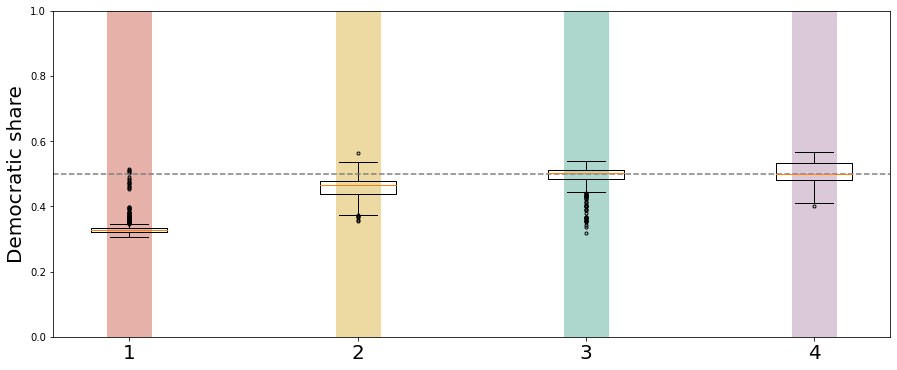

In [7]:
fig, ax = plt.subplots(figsize=(15,6))
mycmap = littlehelpers.gerrybook_cmap
ax.boxplot(
    [[v[x] for v in vote_shares] for x in range(k)],
    positions=[x for x in range(k)],
    widths=2/6,
    sym='.',
    manage_ticks=False
)

for d in range(k):
    ax.axvline(
        d,
        c=mycmap(d),
        linewidth=45,
        alpha=0.5,
        zorder=-100
    )

ax.set_ylim(0,1)
ax.set_xticks(range(k))
ax.set_xticklabels(range(1,k+1), fontsize=20)
ax.axhline(0.5, linestyle='dashed', c='gray')
plt.ylabel('Democratic share', fontsize=20)
plt.show()

## Make the combined heat map and barycenter

In [8]:
gdf['dummy'] = [1]*len(gdf)
wholestate = gdf.dissolve(by='dummy')

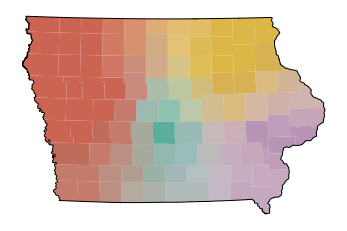

In [9]:
#all together
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
mycmap = littlehelpers.gerrybook_cmap

def mycmap_alpha(alpha, K):
    R = list(mycmap(K))
    R[-1] = alpha
    return tuple(R)

for d in range(k):    
    mycolorarray = np.array([mycmap_alpha(a,d) for a in np.linspace(0,1,10)])    
    newcmp = ListedColormap(mycolorarray)

    in_district = np.array([0]*len(gdf))
    for p in reindexed_plans:
        in_district += [int(p.assignment[x]==d) for x in range(len(gdf))]
    gdf['in'] = in_district
    gdf.plot(column='in',cmap=newcmp, ax=plt.gca())
    
wholestate.boundary.plot( 
    ax=plt.gca(),
    edgecolor='black',
    linewidth=1,
)
plt.axis('off')
plt.show()

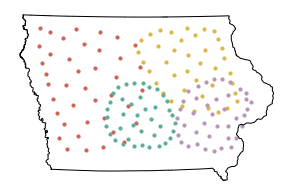

In [10]:
fig, ax = plt.subplots(figsize=(5,6))
mycmap = littlehelpers.gerrybook_cmap
plot_distribution_family(
    [B[j] for j in canonical_order],
    ax=ax, cmap=mycmap, s=10
)
wholestate.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1,
)
ax.axis('off')
plt.show()